In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from os import listdir
from os.path import isfile, join
from IPython.display import display
from PIL import Image

Using TensorFlow backend.


In [2]:
TRAIN_DIR = r"C:\Users\User\Documents\Python Scripts\kaggle\ml100marathon-final\data\kaggle_dogcat\train"
filenames = listdir(TRAIN_DIR)
IMAGE_WIDTH=200
IMAGE_HEIGHT=200
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
import cv2
import os
from random import shuffle
from keras.preprocessing.image import img_to_array
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0]

def create_train_data(TRAIN_DIR):
    train_data = []
    for img in listdir(TRAIN_DIR):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path)
        img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
        #image = img.astype("float") / 255.0
        image = img_to_array(img)
        #image = np.expand_dims(image, axis=0)
        #train_data.append([np.array(img),np.array(label)])
        train_data.append([image,np.array(label)])
    shuffle(train_data)
    np.save('train_data.npy', train_data)
    return train_data

In [4]:
all_data = create_train_data(TRAIN_DIR)
training, testing = train_test_split(all_data, test_size=0.25, random_state=6)

In [ ]:
#from keras.datasets import cifar10
#(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#x_train.shape[1:]

In [5]:
# Resnet v1 共有三個 stage，每經過一次 stage，影像就會變小一半，但 channels 數量增加一倍。ResNet-20 代表共有 20 層 layers，疊越深參數越多
def resnet_v1(input_shape, depth, num_classes):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # 模型的初始設置，要用多少 filters，共有幾個 residual block （組成 ResNet 的單元）
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    
    # 建立 Input layer
    inputs = Input(shape=input_shape)
    
    # 先對影像做第一次卷機
    x = resnet_layer(inputs=inputs)
    
    # 總共建立 3 個 stage
    for stack in range(3):
        # 每個 stage 建立數個 residual blocks (數量視你的層數而訂，越多層越多 block)
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y]) # 此處把 featuremaps 與 上一層的輸入加起來 (欲更了解結構需閱讀原論文)
            x = Activation('relu')(x)
        num_filters *= 2

    # 建立分類
    # 使用 average pooling，且 size 跟 featuremaps 的 size 一樣 （相等於做 GlobalAveragePooling）
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    
    # 接上 Dense layer 來做分類
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # 建立模型
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [6]:
# 使用 resnet_layer 來建立我們的 ResNet 模型
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    # 建立卷積層
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    # 對輸入進行卷機，根據 conv_first 來決定 conv. bn, activation 的順序
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [7]:
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os

# 訓練用的超參數
batch_size=20
epochs = 200
data_augmentation = True
num_classes = 2

# 資料標準化的方式，此處使用減去所有影像的平均值
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 9 # 使用 ResNet-56 的網路架構

# 使用的 ResNet 模型版本
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# 計算不同 ResNet 版本對應的網路深度，此處都是根據 paper 的定義來計算
depth = n * 6 + 2

# 模型的名稱
model_type = 'ResNet%dv%d' % (depth, version)

x_train = []
y_train = []
for data in training:
    x_train.append(data[0])
    y_train.append(data[1])

x_test = []
y_test = []
for t_data in testing:
    x_test.append(t_data[0])
    y_test.append(t_data[1])

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# 影像輸入的維度
input_shape = x_train.shape[1:]

# 先把影像縮放到 0-1 之間
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# 再減去所有影像的平均值
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean 
    x_test -= x_train_mean # 此處要注意！測試資料也是減去訓練資料的平均值來做標準化，不可以減測試資料的平均值 (因為理論上你是不能知道測試資料的平均值的！)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# 對 label 做 one-hot encoding
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# 學習率動態調整。當跑到第幾個 epcoh 時，根據設定修改學習率。這邊的數值都是參考原 paper
def lr_schedule(epoch):
    """Learning Rate Schedule
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


# 建立 ResNet v1 模型
model = resnet_v1(input_shape=input_shape, depth=depth, num_classes=num_classes)

# 編譯模型，使用 Adam 優化器並使用學習率動態調整的函數，０代表在第一個 epochs
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

# 使用動態調整學習率
lr_scheduler = LearningRateScheduler(lr_schedule)

# 使用自動降低學習率 (當 validation loss 連續 5 次沒有下降時，自動降低學習率)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
# 設定 callbacks
callbacks = [lr_reducer, lr_scheduler]


print('Using real-time data augmentation.')
datagen = ImageDataGenerator(
    # set input mean to 0 over the dataset
    featurewise_center=False,
    # set each sample mean to 0
    samplewise_center=False,
    # divide inputs by std of dataset
    featurewise_std_normalization=False,
    # divide each input by its std
    samplewise_std_normalization=False,
    # apply ZCA whitening
    zca_whitening=False,
    # epsilon for ZCA whitening
    zca_epsilon=1e-06,
    # randomly rotate images in the range (deg 0 to 180)
    rotation_range=0,
    # randomly shift images horizontally
    width_shift_range=0.1,
    # randomly shift images vertically
    height_shift_range=0.1,
    # set range for random shear
    shear_range=0.,
    # set range for random zoom
    zoom_range=0.,
    # set range for random channel shifts
    channel_shift_range=0.,
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    # value used for fill_mode = "constant"
    cval=0.,
    # randomly flip images
    horizontal_flip=True,
    # randomly flip images
    vertical_flip=False,
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)

# 將資料送進 ImageDataGenrator 中做增強
datagen.fit(x_train)

W0818 09:48:02.575778 11476 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 09:48:02.589763 11476 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 09:48:02.592756 11476 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0818 09:48:02.624670 11476 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_ses

x_train shape: (3000, 200, 200, 3)
3000 train samples
1000 test samples
y_train shape: (3000, 1)


W0818 09:48:03.740577 11476 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0818 09:48:09.525602 11476 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0818 09:48:09.569482 11476 deprecation_wrapper.py:119] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 200, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 200, 200, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 200, 200, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [8]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=int(len(x_train)//batch_size),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=4,
                    callbacks=callbacks)

# 評估我們的模型
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

W0818 09:48:21.764058 11476 deprecation.py:323] From C:\Users\User\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
Learning rate:  0.001
150/150 [==============================] - 66s 438ms/step - loss: 1.8805 - acc: 0.5677 - val_loss: 1.2754 - val_acc: 0.5930
Epoch 2/200
Learning rate:  0.001
150/150 [==============================] - 52s 347ms/step - loss: 1.1582 - acc: 0.6197 - val_loss: 1.3838 - val_acc: 0.5830
Epoch 3/200
Learning rate:  0.001
150/150 [==============================] - 52s 349ms/step - loss: 1.0729 - acc: 0.6480 - val_loss: 1.0169 - val_acc: 0.6750
Epoch 4/200
Learning rate:  0.001
150/150 [==============================] - 52s 349ms/step - loss: 1.0248 - acc: 0.6797 - val_loss: 1.0691 - val_acc: 0.6730
Epoch 5/200
Learning rate:  0.001
150/150 [==============================] - 52s 349ms/step - loss: 0.9862 - acc: 0.6950 - val_loss: 0.9495 - val_acc: 0.7310
Epoch 6/200
Learning rate:  0.001
150/150 [==============================] - 53s 350ms/step - loss: 0.9515 - acc: 0.7190 - val_loss: 0.9177 - val_acc: 0.7330
Epoch 7/200
Learning rate:  0.001
150/150 [=========

150/150 [==============================] - 52s 350ms/step - loss: 0.3457 - acc: 0.9140 - val_loss: 0.4886 - val_acc: 0.8630
Epoch 53/200
Learning rate:  0.001
150/150 [==============================] - 52s 350ms/step - loss: 0.3606 - acc: 0.9057 - val_loss: 0.5730 - val_acc: 0.8240
Epoch 54/200
Learning rate:  0.001
150/150 [==============================] - 52s 350ms/step - loss: 0.3318 - acc: 0.9197 - val_loss: 1.0711 - val_acc: 0.7380
Epoch 55/200
Learning rate:  0.001
150/150 [==============================] - 52s 350ms/step - loss: 0.3513 - acc: 0.9140 - val_loss: 0.5665 - val_acc: 0.8040
Epoch 56/200
Learning rate:  0.001
150/150 [==============================] - 53s 350ms/step - loss: 0.3304 - acc: 0.9240 - val_loss: 0.4301 - val_acc: 0.8710
Epoch 57/200
Learning rate:  0.001
150/150 [==============================] - 52s 350ms/step - loss: 0.3287 - acc: 0.9220 - val_loss: 0.6075 - val_acc: 0.8210
Epoch 58/200
Learning rate:  0.001
150/150 [==============================] - 53s

150/150 [==============================] - 53s 351ms/step - loss: 0.1486 - acc: 0.9910 - val_loss: 0.3590 - val_acc: 0.9210
Epoch 104/200
Learning rate:  0.0001
150/150 [==============================] - 53s 351ms/step - loss: 0.1465 - acc: 0.9903 - val_loss: 0.3455 - val_acc: 0.9300
Epoch 105/200
Learning rate:  0.0001
150/150 [==============================] - 53s 351ms/step - loss: 0.1398 - acc: 0.9937 - val_loss: 0.3411 - val_acc: 0.9350
Epoch 106/200
Learning rate:  0.0001
150/150 [==============================] - 53s 351ms/step - loss: 0.1401 - acc: 0.9917 - val_loss: 0.3694 - val_acc: 0.9240
Epoch 107/200
Learning rate:  0.0001
150/150 [==============================] - 53s 351ms/step - loss: 0.1401 - acc: 0.9923 - val_loss: 0.3576 - val_acc: 0.9430
Epoch 108/200
Learning rate:  0.0001
150/150 [==============================] - 53s 351ms/step - loss: 0.1373 - acc: 0.9933 - val_loss: 0.4028 - val_acc: 0.9280
Epoch 109/200
Learning rate:  0.0001
150/150 [=========================

150/150 [==============================] - 58s 387ms/step - loss: 0.1160 - acc: 0.9983 - val_loss: 0.3513 - val_acc: 0.9460
Epoch 155/200
Learning rate:  1e-05
150/150 [==============================] - 58s 387ms/step - loss: 0.1157 - acc: 0.9990 - val_loss: 0.3550 - val_acc: 0.9480
Epoch 156/200
Learning rate:  1e-05
150/150 [==============================] - 58s 387ms/step - loss: 0.1134 - acc: 1.0000 - val_loss: 0.3584 - val_acc: 0.9480
Epoch 157/200
Learning rate:  1e-05
150/150 [==============================] - 58s 387ms/step - loss: 0.1152 - acc: 0.9977 - val_loss: 0.3631 - val_acc: 0.9490
Epoch 158/200
Learning rate:  1e-05
150/150 [==============================] - 57s 382ms/step - loss: 0.1181 - acc: 0.9977 - val_loss: 0.3646 - val_acc: 0.9440
Epoch 159/200
Learning rate:  1e-05
150/150 [==============================] - 53s 353ms/step - loss: 0.1171 - acc: 0.9963 - val_loss: 0.3640 - val_acc: 0.9450
Epoch 160/200
Learning rate:  1e-05
150/150 [==============================]

In [9]:
model.save_weights("dog_cat_ResNet_model.h5")

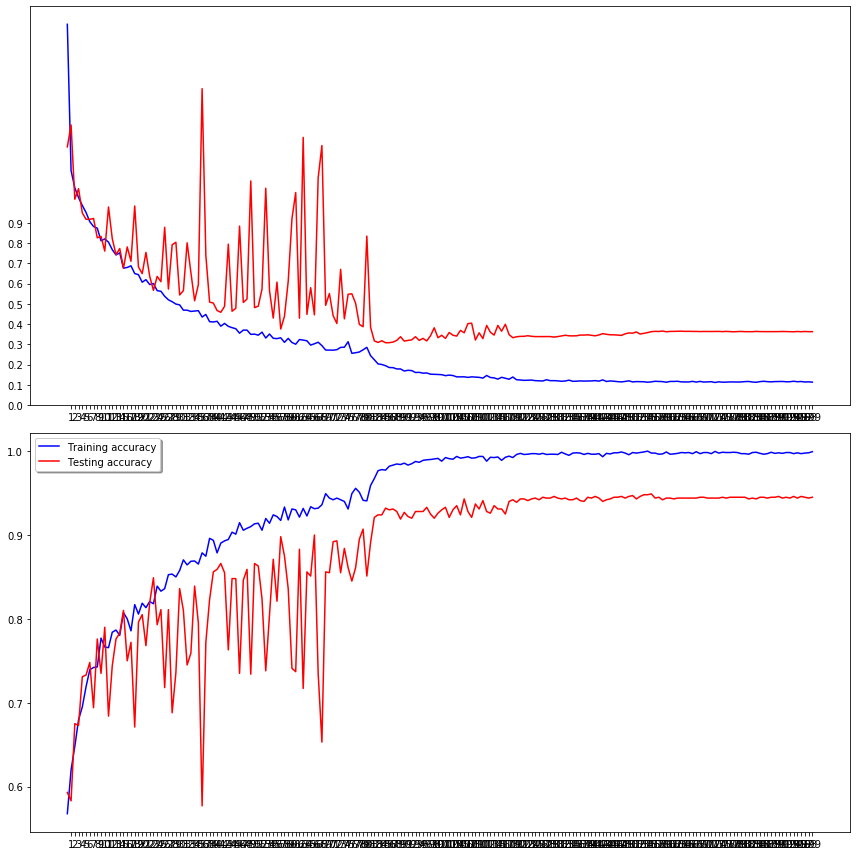

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="Testing loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Testing accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [11]:
test_path = r"C:\Users\User\Documents\Python Scripts\kaggle\ml100marathon-final\data\kaggle_dogcat\test"
test_filenames = listdir(test_path)
test_df = pd.DataFrame({
    'ID': test_filenames,
    'Predicted' : 'NaN'
})
nb_samples = test_df.shape[0]
nb_samples

400

In [12]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_path, 
    x_col='ID',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=1,
    shuffle=False
)

Found 400 validated image filenames.


In [13]:
len(test_generator.filenames)

400

In [17]:
predict = model.predict_generator(test_generator, steps=nb_samples)

In [18]:
len(predict)

400

In [19]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df.head(15)

,ID,Predicted,category
0,000.jpg,NaN,0
1,001.jpg,NaN,1
2,002.jpg,NaN,1
3,003.jpg,NaN,1
4,004.jpg,NaN,0
5,005.jpg,NaN,1
6,006.jpg,NaN,1
7,007.jpg,NaN,0
8,008.jpg,NaN,1
9,009.jpg,NaN,0


In [21]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
#test_df['category'] = test_df['category'].replace({'cat': 0, 'dog': 1})
test_df['category'] = test_df['category'].replace({'cat': 1, 'dog': 0})

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [22]:
test_df.head()

,ID,Predicted,category
0,000.jpg,NaN,0
1,001.jpg,NaN,1
2,002.jpg,NaN,1
3,003.jpg,NaN,1
4,004.jpg,NaN,0


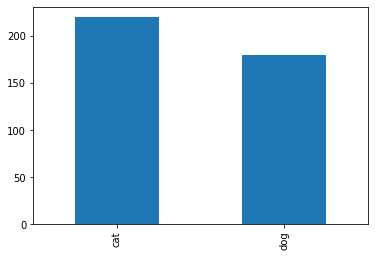

In [40]:
test_df['category'].value_counts().plot.bar()

In [21]:
test_df.head()

,ID,Predicted
0,000.jpg,NaN
1,001.jpg,NaN
2,002.jpg,NaN
3,003.jpg,NaN
4,004.jpg,NaN


In [32]:
probabilities = model.predict_generator(test_generator,test_df.shape[0])

In [33]:
len(probabilities)

400

In [34]:
probabilities

array([[2.89346644e-07, 9.99999762e-01],
       [1.38133817e-06, 9.99998569e-01],
       [9.92752433e-01, 7.24752806e-03],
       [9.99119937e-01, 8.80042149e-04],
       [2.94037909e-06, 9.99997020e-01],
       [4.83128758e-07, 9.99999523e-01],
       [1.68664446e-05, 9.99983191e-01],
       [9.99999642e-01, 3.72956492e-07],
       [6.13056091e-06, 9.99993920e-01],
       [7.32762925e-03, 9.92672384e-01],
       [9.99999404e-01, 5.71372880e-07],
       [3.20644254e-13, 1.00000000e+00],
       [6.21675048e-04, 9.99378324e-01],
       [1.56485805e-06, 9.99998450e-01],
       [8.95308331e-05, 9.99910474e-01],
       [9.99751031e-01, 2.48991448e-04],
       [1.19490693e-07, 9.99999881e-01],
       [9.98097718e-01, 1.90226664e-03],
       [9.90816593e-01, 9.18337889e-03],
       [2.69384710e-08, 1.00000000e+00],
       [2.66830599e-18, 1.00000000e+00],
       [8.10563774e-15, 1.00000000e+00],
       [5.14884060e-03, 9.94851172e-01],
       [1.85072146e-04, 9.99814928e-01],
       [9.974673

In [35]:
for index, probability in enumerate(probabilities):
    #image_path = test_path + "/" + test_generator.filenames[index]
    #img = mpimg.imread(image_path)
    #plt.imshow(img)
    #print(probability)
    test_df.loc[index,["Predicted"]] = probability[0]

In [36]:
test_df.loc[:,["ID","Predicted"]].head()

,ID,Predicted
0,000.jpg,2.89347e-07
1,001.jpg,1.38134e-06
2,002.jpg,0.992752
3,003.jpg,0.99912
4,004.jpg,2.94038e-06


In [37]:
submission_df = test_df.copy()

In [38]:
submission_df["ID"] = submission_df["ID"].str.split('.').str[0]

In [39]:
submission_df.head()

,ID,Predicted,category
0,000,2.89347e-07,0
1,001,1.38134e-06,1
2,002,0.992752,1
3,003,0.99912,1
4,004,2.94038e-06,0


In [40]:
submission_df.loc[:,["ID","Predicted"]].to_csv('submission_10th.csv', index=False)

In [25]:
import matplotlib.image as mpimg

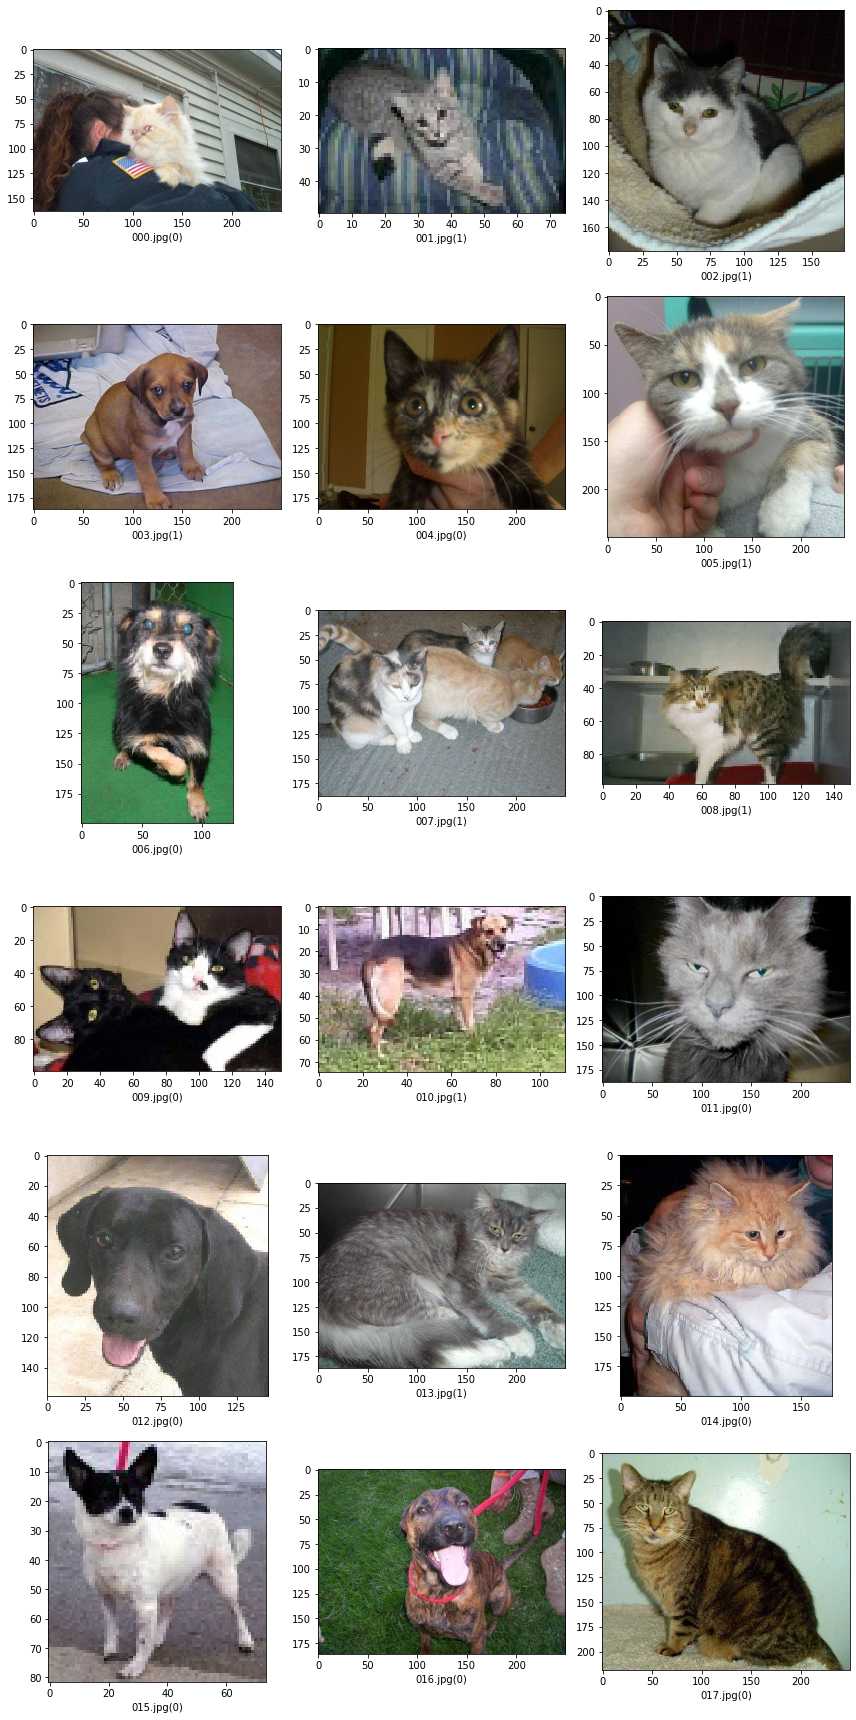

In [55]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    name = test_path + "\\" + filename
    img = mpimg.imread(name)
    
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )

plt.tight_layout()
plt.show()

In [25]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission2.csv', index=False)